<참조 : https://www.tensorflow.org/tutorials/images/data_augmentation>

## Image Data Augmentation

### 01. Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

### 02. Download a dataset

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [ ]:
len(train_ds)

2936

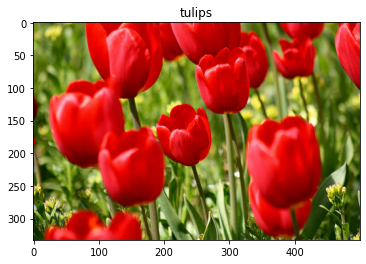

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### 03. Use Keras preprocessing layers

#### 03. 01. Resizing and rescaling

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255)
])

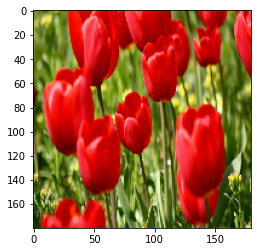

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [ ]:
print('Min and max pixel values: ', result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


#### 03. 02. Data augmentation
- layers.RandomContrast
- layers.RandomCrop
- layers.RandomZoom

In [ ]:
data_augmentation = tf.keras.Sequential([
          layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
          layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

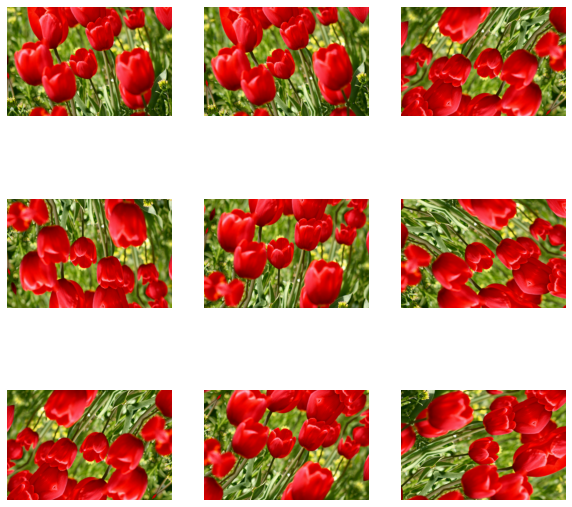

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

#### 03. 03. Two options to use the preprocessing layers

- Option 1 : Make the preprocessing layers part of your model
  - Data augmentation willl run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
  - using **model.save** : 모델을 내보낼 때 전처리 레이어가 모델의 나머지 부분과 함께 저장됩니다. 이 모델을 배포하면 레이어 구성에 따라 이미지가 자동으로 표준화됩니다.

In [ ]:
model = tf.keras.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        # Rest of your model
])

- Option 2 : Apply the preprocessing layers to your dataset
  - CPU에서 비동기적으로 이루어지며 차단되지 않습니다. **Dataset.prefetch**를 사용하여 GPU에서 모델 훈련을 데이터 전처리와 중첩할 수 있습니다.
  - 전처리 레이어는 **model.save**를 호출할 때 모델과 함께 보내지지 않습니다. 저장하기 전에 이 레이어를 모델에 연결하거나 서버측에서 다시 구현해야 합니다.

In [ ]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

#### 03. 04. Apply the preprocessing layers to the datasets

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
    
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

#### 03. 05. Train a model

In [ ]:
model = tf.keras.Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 14s 126ms/step - loss: 1.2826 - accuracy: 0.4608 - val_loss: 1.0478 - val_accuracy: 0.5804
Epoch 2/5
92/92 [==============================] - 10s 99ms/step - loss: 1.0532 - accuracy: 0.5681 - val_loss: 1.0697 - val_accuracy: 0.6076
Epoch 3/5
92/92 [==============================] - 10s 98ms/step - loss: 0.9961 - accuracy: 0.6022 - val_loss: 0.9813 - val_accuracy: 0.6267
Epoch 4/5
92/92 [==============================] - 10s 98ms/step - loss: 0.9250 - accuracy: 0.6247 - val_loss: 0.8675 - val_accuracy: 0.6676
Epoch 5/5
92/92 [==============================] - 10s 101ms/step - loss: 0.8567 - accuracy: 0.6696 - val_loss: 0.8688 - val_accuracy: 0.6567


In [ ]:
loss, acc = model.evaluate(test_ds)
print('Accuracy: ', acc)

12/12 [==============================] - 0s 15ms/step - loss: 0.8047 - accuracy: 0.6703
Accuracy:  0.6702997088432312


#### 03. 06. Custom data augmentation

In [ ]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [ ]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

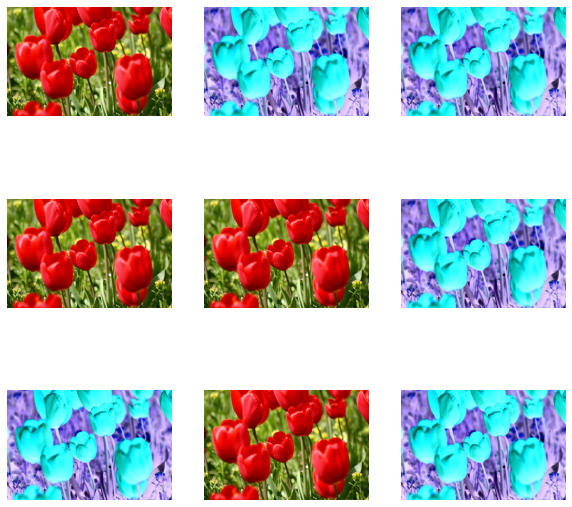

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

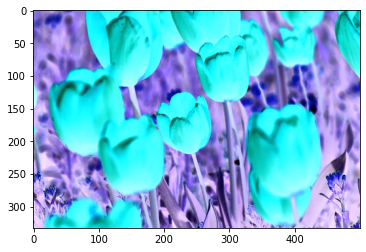

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

### 04. Using tf.image

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

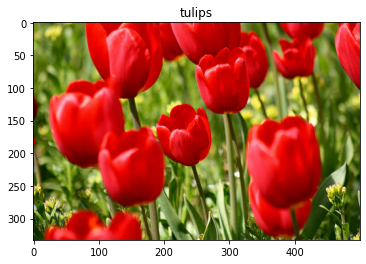

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

#### 04. 01. Data augmentation

- Flipping the image

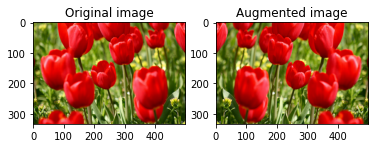

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

- Grayscale the image

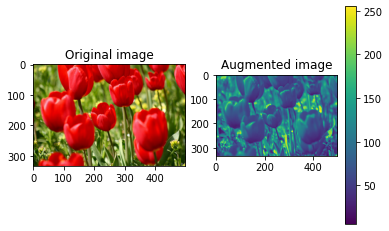

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

- Saturate the image

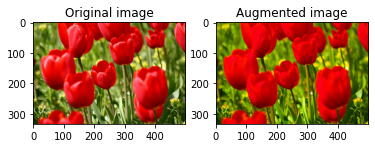

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

- Change image brightness

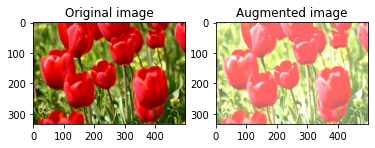

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

- Center crop the image

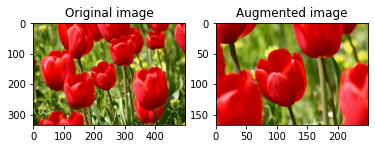

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

- Rotate the image

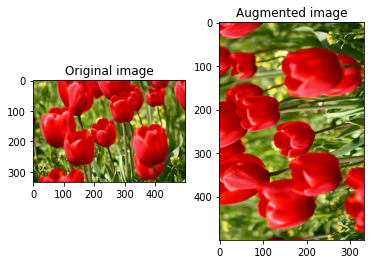

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### 04. 02. Random transformations
- tf.image.stateless_random_brightness
- tf.image.stateless_random_contrast
- tf.image.stateless_random_crop
- tf.image.stateless_random_flip_left_right
- tf.image.stateless_random_flip_up_down
- tf.image.stateless_random_hue
- tf.image.stateless_random_jpeg_quality
- tf.image.stateless_random_saturation

- Go over examples of using random image operations to transform an image.
- Demonstrate how to apply random transformations to a training dataset.

- Randomly change image brightness

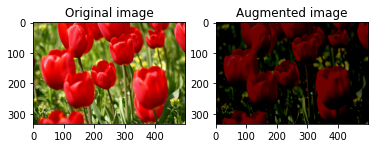

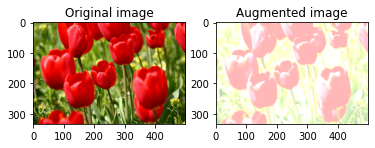

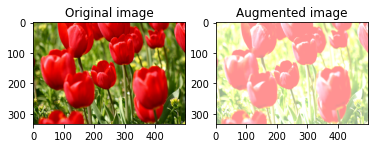

In [ ]:
for i in range(3):
    seed = (i, 0)    # tuple of size (2, )
    stateless_random_brightness = tf.image.stateless_random_brightness(
        image, max_delta=0.95, seed=seed
    )
    visualize(image, stateless_random_brightness)

- Randomly change image contrast

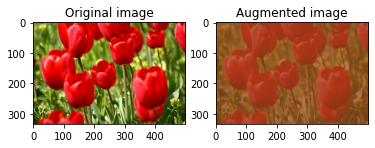

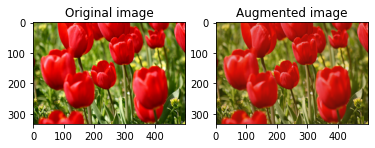

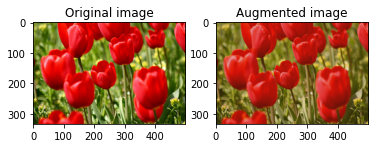

In [ ]:
for i in range(3):
    seed = (i, 0)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.9, seed=seed
    )
    visualize(image, stateless_random_contrast)

- Randomly crop an image

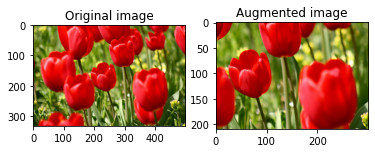

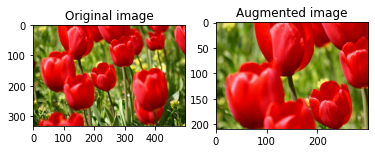

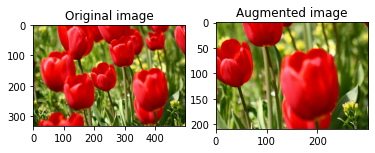

In [ ]:
for i in range(3):
    seed = (i, 0)
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[210, 300, 3], seed=seed
    )
    visualize(image, stateless_random_crop)

#### 04. 03. Apply augmentation to a dataset

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [ ]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+6, IMG_SIZE+6)

    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]

    # Random crop back to the original size
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed
    )

    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )

    image = tf.clip_by_value(image, 0, 1)
    return image, label

- Option 1 : Using **tf.data.experimental.Counter()**

In [ ]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

- Option 2 : Using **tf.random.Generator**

In [ ]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# A wrapper funtion for updating seeds
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
# model = tf.keras.Sequential([
#         layers.Conv2D(16, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(num_classes)
# ])

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [ ]:
# epochs = 5
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs
# )

In [ ]:
# loss, acc = model.evaluate(test_ds)
# print('Accuracy: ', acc)